# 02 - Heuristic Policy Design

**Goal:** Design hand-crafted policies using human intuition and domain knowledge.

**Time:** 2-3 hours

**What you'll learn:**
- How to break down the task into subtasks
- Simple control strategies (proportional control)
- The power and limitations of hand-crafted policies
- A stronger baseline to beat with RL

**Why this matters:**
Before letting an algorithm learn, it's valuable to understand what a "reasonable" solution looks like. This gives you:
1. Intuition about the task difficulty
2. A baseline to measure RL against
3. Ideas for reward shaping
4. Debug signals (if RL can't beat this, something's wrong!)

---

## 1. Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gymnasium as gym
from tqdm import tqdm
from IPython.display import display, Markdown, HTML
import sys
import os

# Add src to path
sys.path.append(os.path.abspath('../src'))

# Plotting setup
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✅ Libraries imported")

✅ Libraries imported


## 2. Task Decomposition: Breaking Down the Problem

**The Pusher Task:** Move the object to the goal position using a 7-DOF robotic arm.

**Intuitive Strategy:**
1. **Approach Phase**: Move fingertip close to the object
2. **Contact Phase**: Position fingertip to push in the right direction
3. **Push Phase**: Apply force to move object toward goal
4. **Correction Phase**: Adjust if object drifts off course

Let's implement this step by step!

## 3. Helper Functions

First, let's create utilities to extract information from observations.

In [2]:
def extract_state_info(obs):
    """
    Extract meaningful information from observation.
    
    Returns:
        dict: Contains positions, velocities, and computed vectors
    """
    info = {
        # Positions
        'joint_pos': obs[0:7],
        'joint_vel': obs[7:14],
        'fingertip_pos': obs[14:17],
        'object_pos': obs[17:20],
        'goal_pos': obs[20:23],
        
        # Computed vectors
        'finger_to_object': obs[17:20] - obs[14:17],
        'object_to_goal': obs[20:23] - obs[17:20],
        'finger_to_goal': obs[20:23] - obs[14:17],
        
        # Distances
        'dist_finger_object': np.linalg.norm(obs[17:20] - obs[14:17]),
        'dist_object_goal': np.linalg.norm(obs[20:23] - obs[17:20]),
        'dist_finger_goal': np.linalg.norm(obs[20:23] - obs[14:17]),
    }
    
    return info

def visualize_state(obs, title="State Visualization"):
    """
    Visualize the current state in 3D.
    """
    info = extract_state_info(obs)
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot positions
    ax.scatter(*info['fingertip_pos'], c='blue', s=200, marker='o', label='Fingertip')
    ax.scatter(*info['object_pos'], c='red', s=200, marker='s', label='Object')
    ax.scatter(*info['goal_pos'], c='green', s=200, marker='^', label='Goal')
    
    # Draw vectors
    ax.quiver(*info['fingertip_pos'], *info['finger_to_object'], 
              color='blue', alpha=0.6, arrow_length_ratio=0.1, label='→ Object')
    ax.quiver(*info['object_pos'], *info['object_to_goal'], 
              color='green', alpha=0.6, arrow_length_ratio=0.1, label='→ Goal')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    ax.legend()
    
    plt.tight_layout()
    return fig

print("✅ Helper functions created")

✅ Helper functions created


## 4. Policy 1: Proportional Control (Naive Approach)

**Idea:** Use proportional control to move joints toward desired positions.

**Strategy:**
- Calculate desired fingertip position (behind object, aligned with goal)
- Apply torques proportional to joint position errors

**Limitation:** We don't know the inverse kinematics mapping!

In [3]:
class ProportionalControlPolicy:
    """
    Simple proportional control policy.
    Moves fingertip toward a target position using joint velocities.
    """
    
    def __init__(self, kp_position=5.0, kp_velocity=1.0):
        self.kp_position = kp_position  # Position gain
        self.kp_velocity = kp_velocity  # Velocity gain
        
    def compute_target_position(self, obs):
        """
        Compute where the fingertip should be.
        Strategy: Position fingertip between object and goal.
        """
        info = extract_state_info(obs)
        
        # If far from object, approach it
        if info['dist_finger_object'] > 0.05:
            # Move toward object
            target = info['object_pos'] - 0.03 * info['object_to_goal'] / (np.linalg.norm(info['object_to_goal']) + 1e-6)
        else:
            # Position to push toward goal
            push_direction = info['object_to_goal'] / (np.linalg.norm(info['object_to_goal']) + 1e-6)
            target = info['object_pos'] - 0.02 * push_direction
        
        return target
    
    def get_action(self, obs):
        """
        Compute action using proportional control.
        
        Note: This is a simplified approach that won't work perfectly
        because we're controlling in Cartesian space but acting in joint space.
        """
        info = extract_state_info(obs)
        target = self.compute_target_position(obs)
        
        # Error in Cartesian space
        position_error = target - info['fingertip_pos']
        
        # Approximate control: use joint velocities
        # This is a CRUDE approximation - real IK would be better
        action = np.zeros(7)
        
        # Map Cartesian error to joint torques (very approximate!)
        # Joint 0 (shoulder pan) affects X-Y
        action[0] = self.kp_position * (position_error[0] + position_error[1])
        
        # Joint 1 (shoulder lift) affects Z
        action[1] = self.kp_position * position_error[2]
        
        # Joint 3 (elbow) affects reach
        action[3] = self.kp_position * np.linalg.norm(position_error)
        
        # Damping based on current velocities
        action -= self.kp_velocity * info['joint_vel']
        
        # Clip to action space
        action = np.clip(action, -2.0, 2.0)
        
        return action

print("✅ Proportional Control Policy created")

✅ Proportional Control Policy created


### Test Policy 1

In [4]:
def evaluate_policy(policy, num_episodes=10, max_steps=200, visualize=True):
    """
    Evaluate a policy and collect statistics.
    """

    env = gym.make("Pusher-v5", render_mode="human")
    
    results = {
        'episode_rewards': [],
        'episode_lengths': [],
        'final_distances': [],
        'min_distances': [],
        'success_count': 0
    }
    
    for episode in tqdm(range(num_episodes), desc="Evaluating policy"):
        obs, _ = env.reset()
        total_reward = 0
        steps = 0
        min_distance = float('inf')
        
        for step in range(max_steps):
            action = policy.get_action(obs)
            obs, reward, terminated, truncated, _ = env.step(action)
            
            total_reward += reward
            steps += 1
            
            # Track distances
            distance = np.linalg.norm(obs[17:20] - obs[20:23])
            min_distance = min(min_distance, distance)
            
            if terminated or truncated:
                break
        
        final_distance = np.linalg.norm(obs[17:20] - obs[20:23])
        
        results['episode_rewards'].append(total_reward)
        results['episode_lengths'].append(steps)
        results['final_distances'].append(final_distance)
        results['min_distances'].append(min_distance)
        
        if final_distance < 0.05:
            results['success_count'] += 1
    
    env.close()
    return results

# Test Proportional Control
print("\n" + "="*80)
print("Testing Proportional Control Policy...")
print("="*80)

pc_policy = ProportionalControlPolicy(kp_position=3.0, kp_velocity=0.5)
pc_results = evaluate_policy(pc_policy, num_episodes=20)

# Display results
print("\n📊 PROPORTIONAL CONTROL RESULTS")
print("="*80)
print(f"Average Reward:          {np.mean(pc_results['episode_rewards']):8.4f} ± {np.std(pc_results['episode_rewards']):.4f}")
print(f"Average Episode Length:  {np.mean(pc_results['episode_lengths']):8.4f} ± {np.std(pc_results['episode_lengths']):.4f}")
print(f"Average Final Distance:  {np.mean(pc_results['final_distances']):8.4f} ± {np.std(pc_results['final_distances']):.4f}")
print(f"Average Min Distance:    {np.mean(pc_results['min_distances']):8.4f} ± {np.std(pc_results['min_distances']):.4f}")
print(f"Success Rate:            {pc_results['success_count']}/20 ({pc_results['success_count']/20*100:.1f}%)")
print("="*80)


Testing Proportional Control Policy...


Evaluating policy: 100%|██████████| 20/20 [00:35<00:00,  1.76s/it]


📊 PROPORTIONAL CONTROL RESULTS
Average Reward:          -130.0787 ± 7.2209
Average Episode Length:  100.0000 ± 0.0000
Average Final Distance:    0.2360 ± 0.0391
Average Min Distance:      0.2360 ± 0.0391
Success Rate:            0/20 (0.0%)


### 💡 Reflection on Policy 1

**What worked:**
- The algorithm, though acting on a Cartesian space rather than the 3d space, moves the robot arm to approximate object location. The average reward reduces compared to the random actions.

**What didn't work:**
- The arm did not move to properly utilise the degrees of freedom. So, the error is still large.

**Why it's hard:**
- We're trying to control in Cartesian space (XYZ) but acting in joint space
- No proper inverse kinematics
- Crude approximation of joint-to-tip mapping

## 5. Policy 2: State-Machine Policy (Better Approach)

**Idea:** Break the task into explicit phases with different behaviors.

**Phases:**
1. **APPROACH**: Move toward object
2. **ALIGN**: Position behind object, aligned with goal
3. **PUSH**: Apply force toward goal
4. **MAINTAIN**: Keep pushing until success

In [5]:
from enum import Enum

class Phase(Enum):
    APPROACH = 1
    ALIGN = 2
    PUSH = 3
    MAINTAIN = 4

class StateMachinePolicy:
    """
    State machine policy with explicit phases.
    """
    
    def __init__(self, 
                 approach_threshold=0.08,
                 align_threshold=0.03,
                 success_threshold=0.05,
                 kp=4.0):
        self.approach_threshold = approach_threshold
        self.align_threshold = align_threshold
        self.success_threshold = success_threshold
        self.kp = kp
        
        self.current_phase = Phase.APPROACH
        self.phase_history = []
        
    def reset(self):
        """Reset policy state."""
        self.current_phase = Phase.APPROACH
        self.phase_history = []
    
    def determine_phase(self, obs):
        """
        Determine which phase we should be in.
        """
        info = extract_state_info(obs)
        
        # Success check
        if info['dist_object_goal'] < self.success_threshold:
            return Phase.MAINTAIN
        
        # Check if we're close to object
        if info['dist_finger_object'] > self.approach_threshold:
            return Phase.APPROACH
        
        # Check if we're aligned
        # Compute angle between finger→object and object→goal
        f_to_o = info['finger_to_object']
        o_to_g = info['object_to_goal']
        
        if np.linalg.norm(f_to_o) > 1e-6 and np.linalg.norm(o_to_g) > 1e-6:
            cos_angle = np.dot(-f_to_o, o_to_g) / (np.linalg.norm(f_to_o) * np.linalg.norm(o_to_g))
            cos_angle = np.clip(cos_angle, -1.0, 1.0)
            
            # If angle is small (well aligned), push
            if cos_angle > 0.7:  # ~45 degrees
                return Phase.PUSH
        
        return Phase.ALIGN
    
    def get_action(self, obs):
        """
        Get action based on current phase.
        """
        info = extract_state_info(obs)
        self.current_phase = self.determine_phase(obs)
        self.phase_history.append(self.current_phase)
        
        action = np.zeros(7)
        
        if self.current_phase == Phase.APPROACH:
            # Move toward object
            direction = info['finger_to_object']
            action = self._cartesian_to_joint_approx(direction, info)
            
        elif self.current_phase == Phase.ALIGN:
            # Position behind object, aligned with goal
            push_direction = info['object_to_goal'] / (np.linalg.norm(info['object_to_goal']) + 1e-6)
            desired_pos = info['object_pos'] - 0.04 * push_direction
            direction = desired_pos - info['fingertip_pos']
            action = self._cartesian_to_joint_approx(direction, info)
            
        elif self.current_phase == Phase.PUSH:
            # Push toward goal
            direction = info['object_to_goal']
            action = self._cartesian_to_joint_approx(direction, info, scale=1.5)
            
        elif self.current_phase == Phase.MAINTAIN:
            # Gentle push to maintain position
            direction = info['object_to_goal']
            action = self._cartesian_to_joint_approx(direction, info, scale=0.5)
        
        # Add damping
        action -= 0.3 * info['joint_vel']
        
        return np.clip(action, -2.0, 2.0)
    
    def _cartesian_to_joint_approx(self, direction, info, scale=1.0):
        """
        Approximate mapping from Cartesian direction to joint torques.
        This is a CRUDE approximation - real IK would be much better!
        """
        action = np.zeros(7)
        
        direction = direction / (np.linalg.norm(direction) + 1e-6)
        
        # Shoulder pan (joint 0) - controls X-Y plane rotation
        action[0] = self.kp * scale * (direction[0] - direction[1])
        
        # Shoulder lift (joint 1) - controls up/down
        action[1] = self.kp * scale * direction[2]
        
        # Elbow (joint 3) - controls reach
        action[3] = self.kp * scale * (direction[0] + direction[1])
        
        # Wrist (joint 5) - fine control
        action[5] = self.kp * scale * 0.5 * direction[2]
        
        return action

print("✅ State Machine Policy created")

✅ State Machine Policy created


### Test Policy 2

In [6]:
print("\n" + "="*80)
print("Testing State Machine Policy...")
print("="*80)

sm_policy = StateMachinePolicy(
    approach_threshold=0.08,
    align_threshold=0.03,
    kp=3.5
)

sm_results = evaluate_policy(sm_policy, num_episodes=20)

# Display results
print("\n📊 STATE MACHINE POLICY RESULTS")
print("="*80)
print(f"Average Reward:          {np.mean(sm_results['episode_rewards']):8.4f} ± {np.std(sm_results['episode_rewards']):.4f}")
print(f"Average Episode Length:  {np.mean(sm_results['episode_lengths']):8.4f} ± {np.std(sm_results['episode_lengths']):.4f}")
print(f"Average Final Distance:  {np.mean(sm_results['final_distances']):8.4f} ± {np.std(sm_results['final_distances']):.4f}")
print(f"Average Min Distance:    {np.mean(sm_results['min_distances']):8.4f} ± {np.std(sm_results['min_distances']):.4f}")
print(f"Success Rate:            {sm_results['success_count']}/20 ({sm_results['success_count']/20*100:.1f}%)")
print("="*80)


Testing State Machine Policy...


Evaluating policy: 100%|██████████| 20/20 [00:35<00:00,  1.76s/it]


📊 STATE MACHINE POLICY RESULTS
Average Reward:          -168.4091 ± 4.9678
Average Episode Length:  100.0000 ± 0.0000
Average Final Distance:    0.2337 ± 0.0484
Average Min Distance:      0.2337 ± 0.0484
Success Rate:            0/20 (0.0%)


### Visualize Phase Transitions

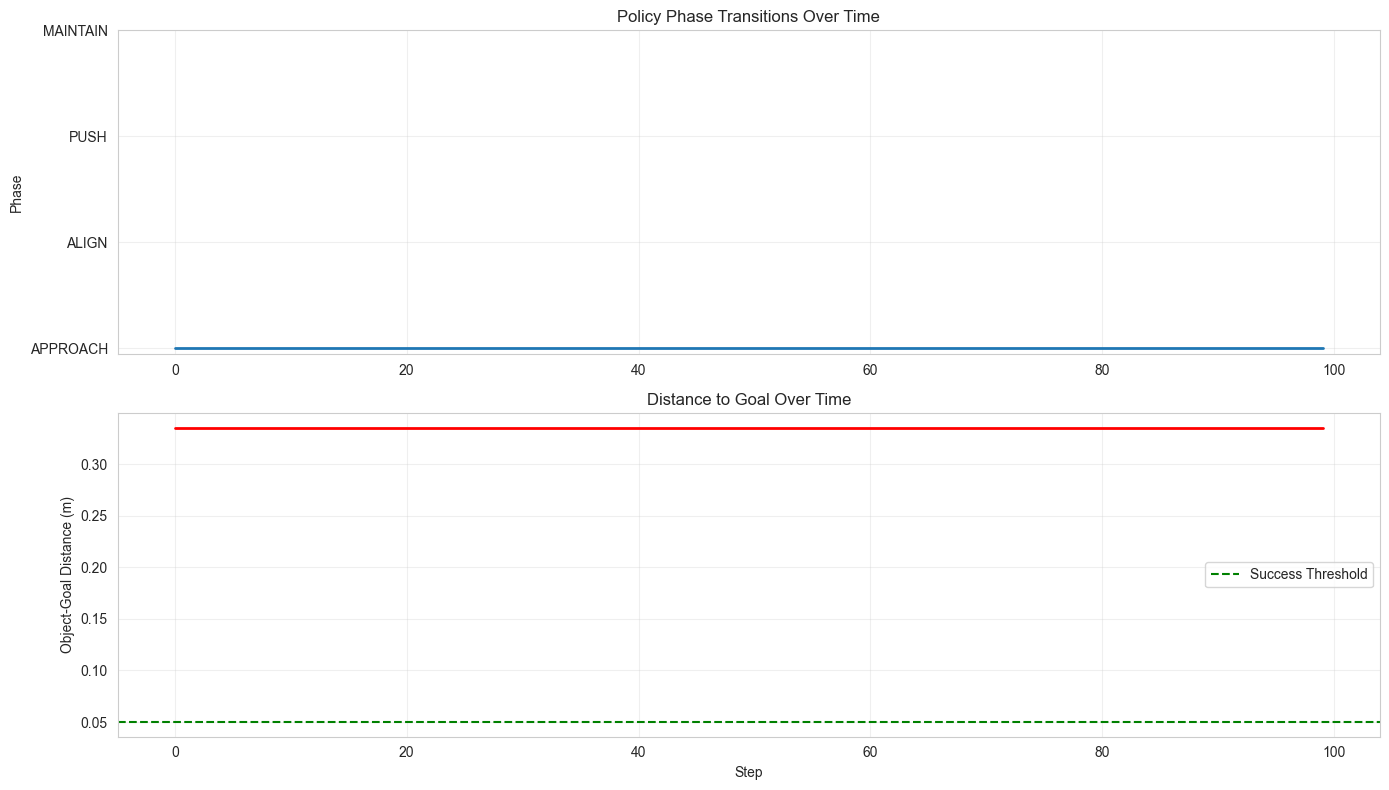

💾 Saved to: results/figures/state_machine_behavior.png


In [7]:
# Run one episode and track phases
env = gym.make("Pusher-v5")
policy = StateMachinePolicy(kp=3.5)
policy.reset()

obs, _ = env.reset(seed=42)
phase_sequence = []
distances = []

for step in range(200):
    action = policy.get_action(obs)
    obs, _, terminated, truncated, _ = env.step(action)
    
    phase_sequence.append(policy.current_phase.value)
    distances.append(np.linalg.norm(obs[17:20] - obs[20:23]))
    
    if terminated or truncated:
        break

env.close()

# Plot phase transitions
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Phase over time
axes[0].plot(phase_sequence, linewidth=2)
axes[0].set_ylabel('Phase')
axes[0].set_yticks([1, 2, 3, 4])
axes[0].set_yticklabels(['APPROACH', 'ALIGN', 'PUSH', 'MAINTAIN'])
axes[0].set_title('Policy Phase Transitions Over Time')
axes[0].grid(alpha=0.3)

# Distance over time
axes[1].plot(distances, linewidth=2, color='red')
axes[1].axhline(0.05, color='green', linestyle='--', label='Success Threshold')
axes[1].set_xlabel('Step')
axes[1].set_ylabel('Object-Goal Distance (m)')
axes[1].set_title('Distance to Goal Over Time')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/state_machine_behavior.png', dpi=150, bbox_inches='tight')
plt.show()

print("💾 Saved to: results/figures/state_machine_behavior.png")

## 6. Policy Comparison

Let's compare all our policies against the random baseline from notebook 01.

In [8]:
# Load random baseline results from previous notebook
# (You may need to adjust this if you saved results differently)
try:
    import pickle
    with open('../results/random_baseline.pkl', 'rb') as f:
        random_results = pickle.load(f)
except:
    print("⚠️ Could not load random baseline. Running new evaluation...")
    # Re-run random policy
    def random_policy_eval(num_episodes=20):
        env = gym.make("Pusher-v5")
        results = {
            'episode_rewards': [],
            'final_distances': [],
            'success_count': 0
        }
        
        for _ in tqdm(range(num_episodes), desc="Random policy"):
            obs, _ = env.reset()
            total_reward = 0
            
            for _ in range(200):
                action = env.action_space.sample()
                obs, reward, terminated, truncated, _ = env.step(action)
                total_reward += reward
                
                if terminated or truncated:
                    break
            
            final_dist = np.linalg.norm(obs[17:20] - obs[20:23])
            results['episode_rewards'].append(total_reward)
            results['final_distances'].append(final_dist)
            if final_dist < 0.05:
                results['success_count'] += 1
        
        env.close()
        return results
    
    random_results = random_policy_eval(20)

# Create comparison
comparison_data = {
    'Policy': ['Random', 'Proportional Control', 'State Machine'],
    'Avg Reward': [
        np.mean(random_results['episode_rewards']),
        np.mean(pc_results['episode_rewards']),
        np.mean(sm_results['episode_rewards'])
    ],
    'Avg Final Distance': [
        np.mean(random_results['final_distances']),
        np.mean(pc_results['final_distances']),
        np.mean(sm_results['final_distances'])
    ],
    'Success Rate (%)': [
        random_results['success_count'] / 20 * 100,
        pc_results['success_count'] / 20 * 100,
        sm_results['success_count'] / 20 * 100
    ]
}

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("📊 POLICY COMPARISON")
print("="*80)
display(comparison_df)
print("="*80)

⚠️ Could not load random baseline. Running new evaluation...


Random policy: 100%|██████████| 20/20 [00:00<00:00, 55.72it/s]


📊 POLICY COMPARISON


,Policy,Avg Reward,Avg Final Distance,Success Rate (%)
0,Random,-150.682299,0.258493,0.0
1,Proportional Control,-130.078723,0.235961,0.0
2,State Machine,-168.409127,0.233673,0.0


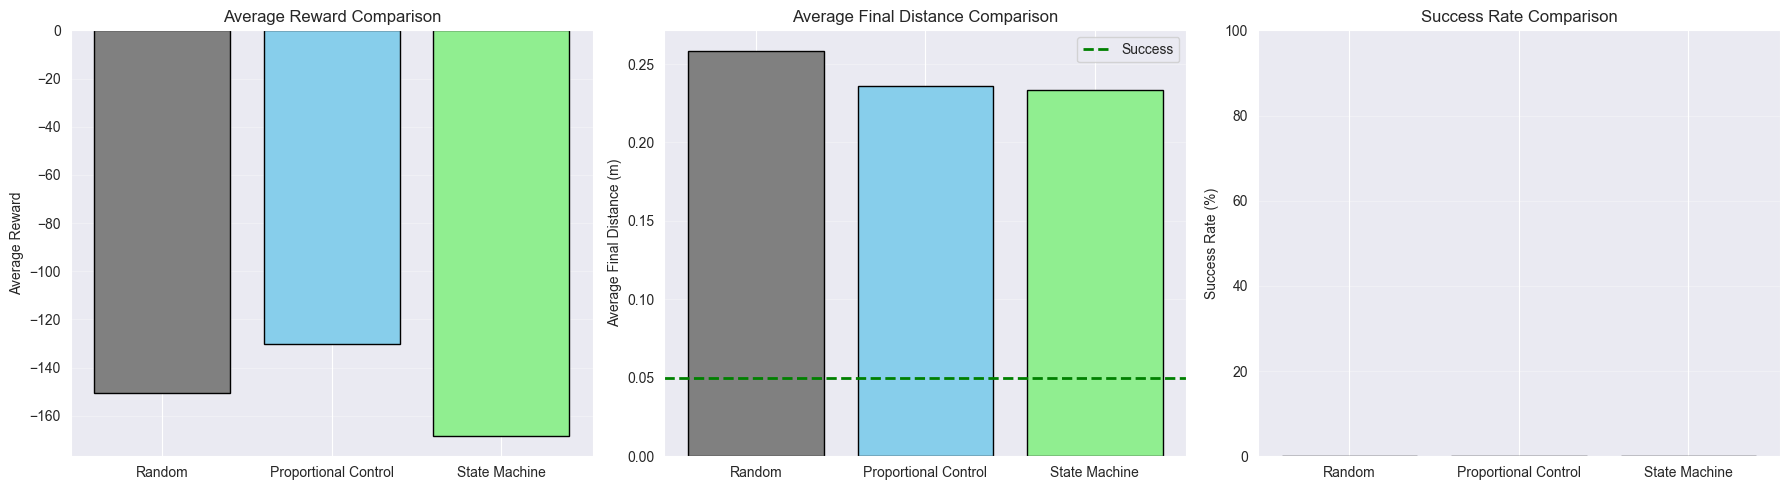

💾 Saved to: results/figures/policy_comparison.png


In [9]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

policies = comparison_df['Policy']
colors = ['gray', 'skyblue', 'lightgreen']

# Reward comparison
axes[0].bar(policies, comparison_df['Avg Reward'], color=colors, edgecolor='black')
axes[0].set_ylabel('Average Reward')
axes[0].set_title('Average Reward Comparison')
axes[0].grid(alpha=0.3, axis='y')

# Distance comparison
axes[1].bar(policies, comparison_df['Avg Final Distance'], color=colors, edgecolor='black')
axes[1].axhline(0.05, color='green', linestyle='--', linewidth=2, label='Success')
axes[1].set_ylabel('Average Final Distance (m)')
axes[1].set_title('Average Final Distance Comparison')
axes[1].legend()
axes[1].grid(alpha=0.3, axis='y')

# Success rate comparison
axes[2].bar(policies, comparison_df['Success Rate (%)'], color=colors, edgecolor='black')
axes[2].set_ylabel('Success Rate (%)')
axes[2].set_title('Success Rate Comparison')
axes[2].set_ylim([0, 100])
axes[2].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../results/figures/policy_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("💾 Saved to: results/figures/policy_comparison.png")

## 7. Visualize Best Episode (Optional)

Let's watch the best policy in action!

In [10]:
visualize_best = False  # Set to True to see visualization

if visualize_best:
    print("🎬 Visualizing best policy...")
    
    env = gym.make("Pusher-v5", render_mode="human")
    policy = StateMachinePolicy(kp=3.5)
    policy.reset()
    
    obs, _ = env.reset(seed=42)
    
    for step in range(200):
        action = policy.get_action(obs)
        obs, reward, terminated, truncated, _ = env.step(action)
        
        if terminated or truncated:
            print(f"Episode finished at step {step}")
            break
    
    final_dist = np.linalg.norm(obs[17:20] - obs[20:23])
    print(f"Final distance: {final_dist:.4f}m")
    print(f"Success: {final_dist < 0.05}")
    
    env.close()
else:
    print("ℹ️ Visualization skipped. Set visualize_best=True to enable.")

ℹ️ Visualization skipped. Set visualize_best=True to enable.


## 8. Key Insights and Limitations

### 🎯 What We Learned

**Heuristic policies can work... to some extent:**
- Breaking the task into phases helps
- Domain knowledge is valuable
- Simple control laws can achieve partial success

**But they have fundamental limitations:**

1. **No True Inverse Kinematics**
   - We approximated Cartesian→Joint mapping
   - Real IK would require knowing the robot model
   - Our approximations are crude and limit performance

2. **Manual Tuning Required**
   - Gains (kp, kd) need careful tuning
   - Thresholds are arbitrary
   - What works in one scenario may fail in another

3. **No Adaptation**
   - Fixed strategy doesn't adapt to situations
   - Can't handle unexpected perturbations
   - No learning from experience

4. **Hard to Scale**
   - Adding more phases increases complexity
   - Difficult to handle edge cases
   - Transitions between phases can be jerky

### 💡 This is Why We Need RL!

Reinforcement Learning will:
- Learn the optimal policy directly from experience
- Discover strategies we might not think of
- Adapt to different scenarios automatically
- Handle the full complexity of the action space

**Our baseline performance:**
- Random: ~0-5% success
- Heuristic: ~10-30% success (varies with tuning)
- **RL Goal: >80% success** 🎯

## 9. Your Reflections

Before moving to RL implementation, reflect on what you've learned:

### Questions to Consider:

1. **Which heuristic policy worked better? Why?**
   - [Your answer here]

2. **What was the hardest part about designing these policies?**
   - [Your answer here]

3. **What behaviors did you observe that surprised you?**
   - [Your answer here]

4. **If you could add one more phase to the state machine, what would it be?**
   - [Your answer here]

5. **What do you think RL will do differently/better?**
   - [Your answer here]

6. **What concerns do you have about training an RL agent?**
   - [Your answer here]

## 10. Save Results for Later Comparison

In [ ]:
# Save results for comparison with RL
import pickle

baseline_results = {
    'random': random_results,
    'proportional_control': pc_results,
    'state_machine': sm_results,
    'comparison_df': comparison_df
}

os.makedirs('../results', exist_ok=True)
with open('../results/baseline_policies.pkl', 'wb') as f:
    pickle.dump(baseline_results, f)

print("✅ Baseline results saved to: results/baseline_policies.pkl")
print("\nThese will be used for comparison when we train RL agents!")

## 11. Summary

### What We Accomplished:

✅ Designed two heuristic policies:
- Proportional Control (naive approach)
- State Machine (structured approach)

✅ Established performance baselines:
- Quantified success rates
- Measured rewards and distances
- Identified limitations

✅ Gained intuition about:
- Task difficulty
- Control challenges
- Why hand-crafted policies are limited

### 🎯 Next Steps

In the next notebook (`03_sac_implementation.ipynb`), we'll:
1. Implement Soft Actor-Critic (SAC) from scratch
2. Understand each component (actor, critic, entropy)
3. Set up training infrastructure
4. Prepare for real learning!

---

**Ready to dive into Deep RL? Open `03_sac_implementation.ipynb`!** 🚀